# Alcohol Consumption and Student Performance

## Introduction

Drinking alcohol is part of daily life for many people. Many students also drink alcohol as a means to cope with stress. However alcohol can damage people's bodies, nerves (1) and lead to aggressive behavior (2). Our group was interested in whether alcohol consumption has an effect on the performance of different types of students. According to a study by Ansari, Stock and Mills in 2013, alcohol consumption is negatively associated with student achievement (3). For our group project, we chose to use the data, specifically the processed student alcohol consumption dataset (https://www.kaggle.com/datasets/uciml/student-alcohol-consumption). The dataset contains students' gender, age, length of study, number of absences, weekend alcohol consumption (presented as a scale from 1 to 5, with 1 being very low and 5 being very high) and final grades (G3). The question we wish to investigate is whether weekend drinking has a greater effect on student academic grades. We will determine the final conclusion by calculating a location parameter consisting of the mean of student grades among two groups -- high alcohol consumption and low alcohol consumption. We are also interested in calculating an inter-quartile range (IQR) as the scale parameter.

## Method and Results

### Preliminary Analysis and Results

#### Preparing Data

We begin by preparing the required packages and reading our data set from the web.

In [26]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
library(digest)
library(infer)
library(repr)

In [27]:
url <-"https://raw.githubusercontent.com/jtan29/stat-201-project/main/student-mat.csv"
student_data <- read_csv(url)
head(student_data)

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


Selecting relevant columns: student final grade and level of weekend alcohol consumption. Alcohol consumption amount is provided on a scale of 1 to 5, with 1 being very low and 5 being very high. We have denoted a consumption level above 2 to be "high".

In [28]:
student_data_clean <- 
    student_data %>%
    select(Walc, G3) %>%
    mutate(high_alc = Walc > 2)

head(student_data_clean)

Walc,G3,high_alc
<dbl>,<dbl>,<lgl>
1,6,FALSE
1,6,FALSE
3,10,TRUE
1,15,FALSE
2,10,FALSE
2,15,FALSE


#### Analysis of Raw Data

Then, we determine the average grade and the standard deviation of grades for the high and low consumption groups.

In [4]:
student_summary <-
    student_data_clean %>%
    group_by(high_alc) %>%
    summarize(count = n(),
             mean_grade = mean(G3),
             sd_grade = sd(G3))

low_alc_mean = student_summary$mean_grade[[1]]
high_alc_mean = student_summary$mean_grade[[2]]
total_count = student_summary$count[[1]] + student_summary$count[[2]]
student_summary
total_count

high_alc,count,mean_grade,sd_grade
<lgl>,<int>,<dbl>,<dbl>
FALSE,236,10.50000,5.067628
TRUE,159,10.28931,3.757433


[1] 395

Then we plot the sampling distribution of student grades for both groups.

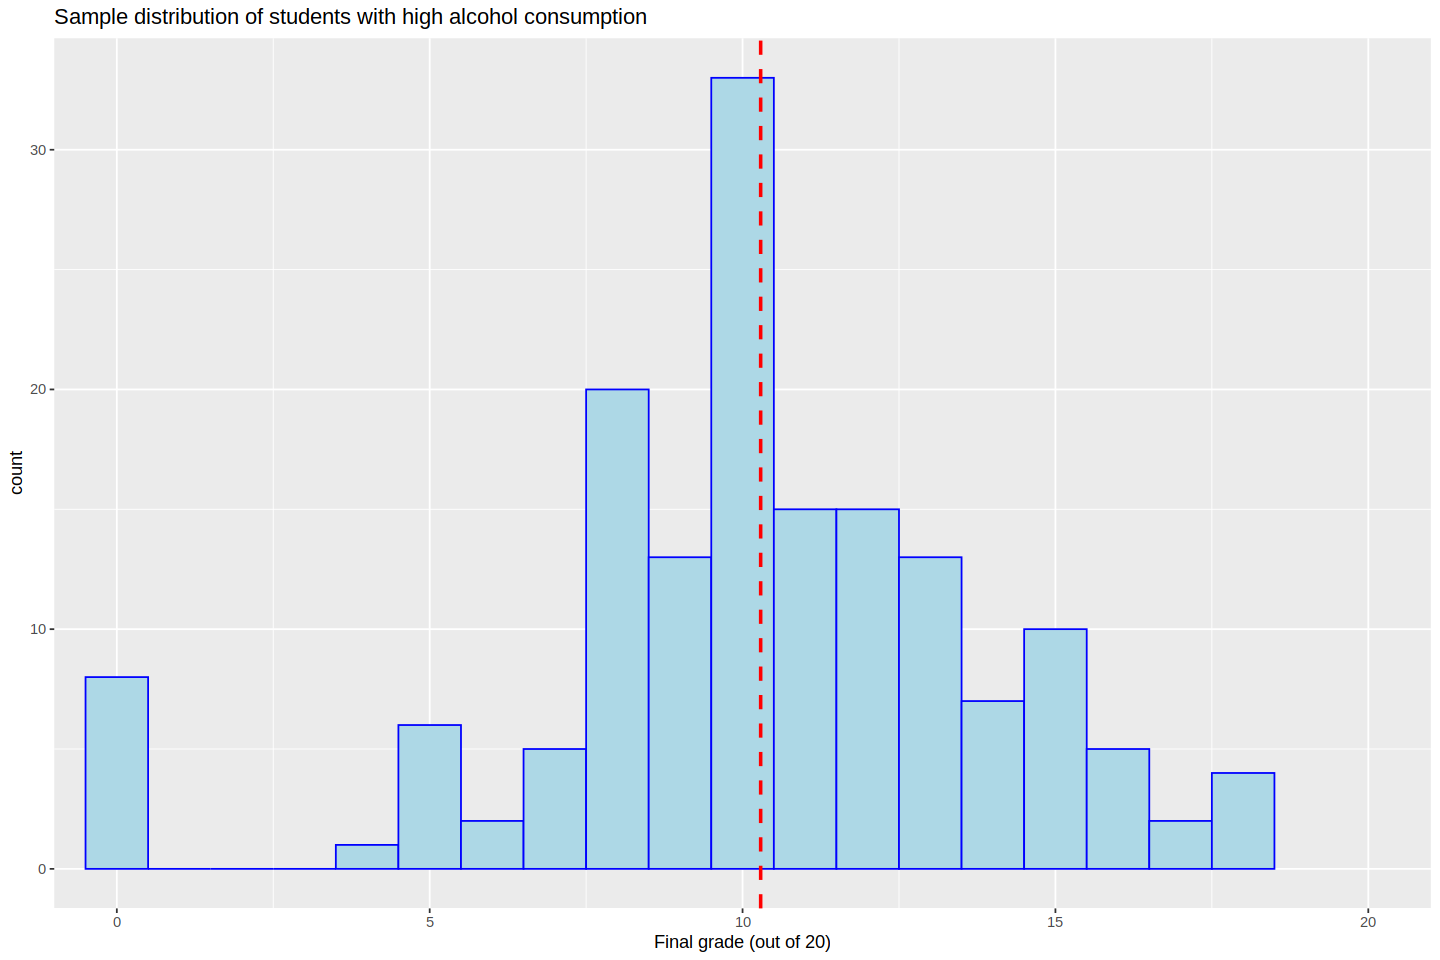

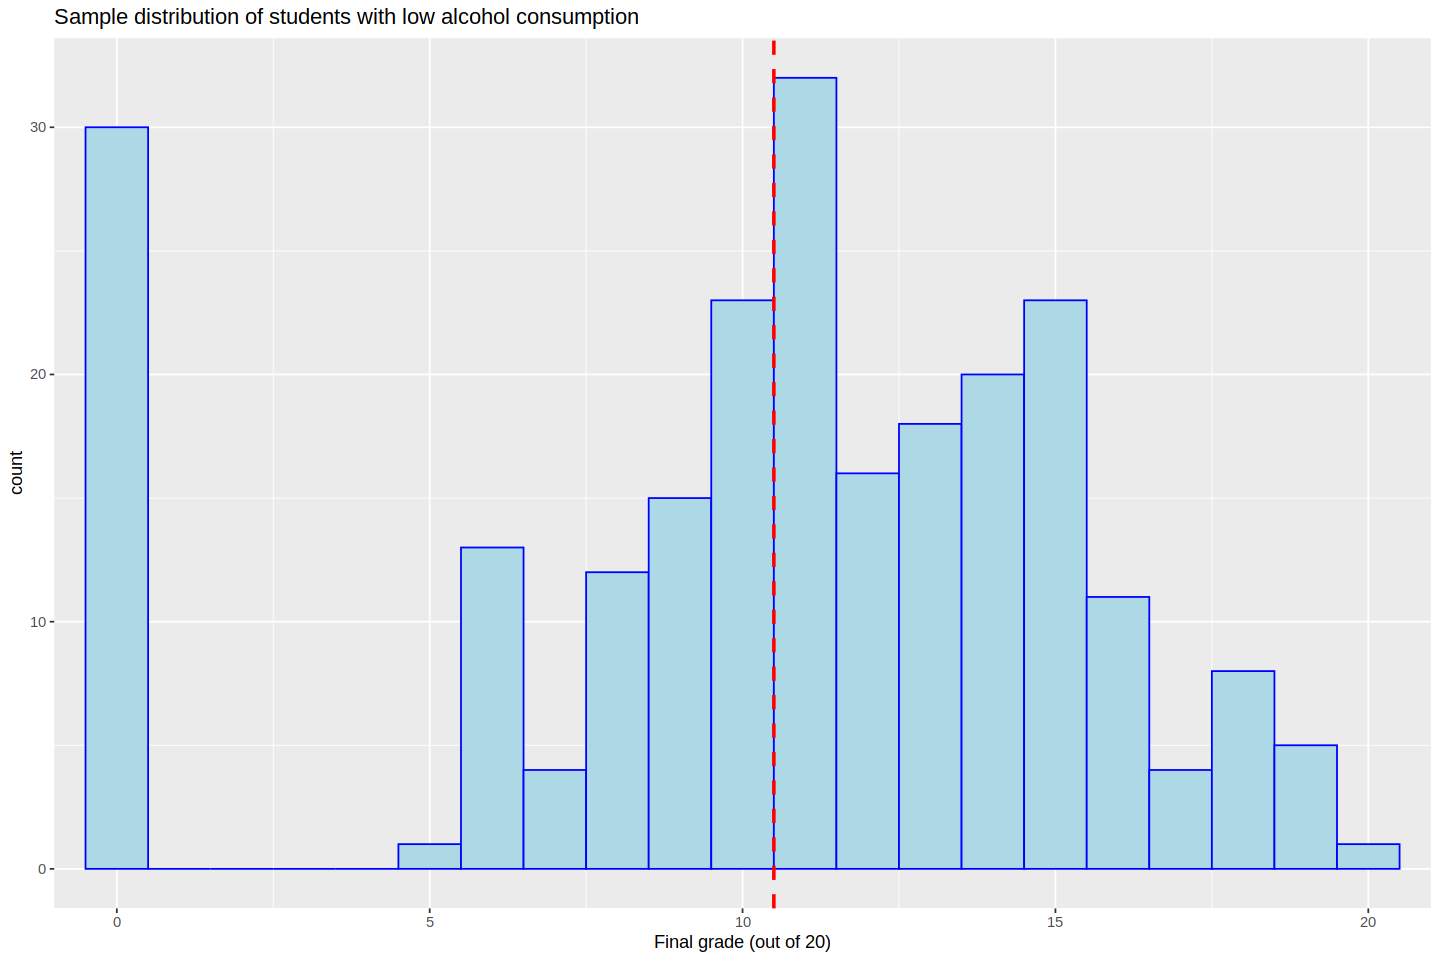

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)

high_alc_sample_dist <-
    student_data_clean %>%
    filter(high_alc == TRUE) %>%
    ggplot(aes(x = G3)) +
    geom_histogram(binwidth = 1, fill = "lightblue",  color  = "blue") +
    labs(title = "Sample distribution of students with high alcohol consumption", x = "Final grade (out of 20)") +
    geom_vline(aes(xintercept = high_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
    coord_cartesian(xlim = c(0, 20))


high_alc_sample_dist
    
low_alc_sample_dist <-
    student_data_clean %>%
    filter(high_alc == FALSE) %>%
    ggplot(aes(x = G3)) +
    geom_histogram(binwidth = 1, fill = "lightblue",  color  = "blue") +
    labs(title = "Sample distribution of students with low alcohol consumption", x = "Final grade (out of 20)") +
    geom_vline(aes(xintercept = low_alc_mean), linetype = "dashed", color = "red", linewidth = 1) +
    coord_cartesian(xlim = c(0, 20))


low_alc_sample_dist

We can also visually inspect a boxplot of the two groups.

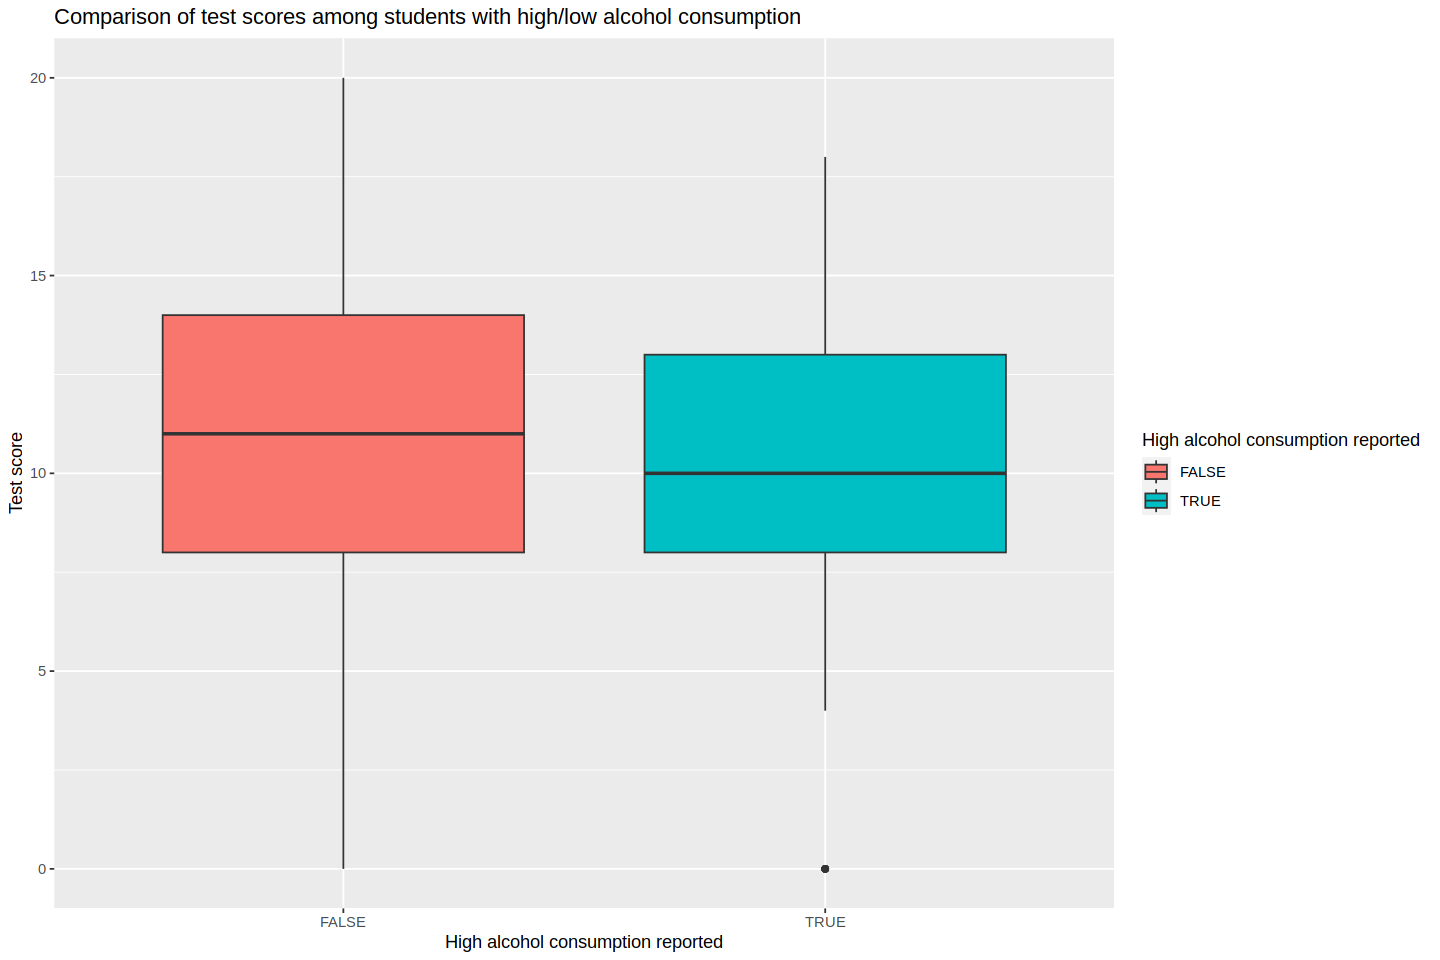

In [6]:
boxplot <- student_data_clean %>%
              ggplot() +
              geom_boxplot(aes(x = high_alc, y = G3, fill = high_alc)) +
              labs(x = "High alcohol consumption reported", 
                   y = "Test score", 
                   fill = "High alcohol consumption reported", 
                   title = "Comparison of test scores among students with high/low alcohol consumption")
boxplot

Our anticipated result, based on existing literature on alcohol consumption, is that students with lower alcohol consumption receive higher grades on average (alternatively, this can be restated as students with higher reported alcohol consumption receiving lower grades on average). This is supported by the lower raw mean final grade in the high consumption group in our preliminary results, as can be observed in the boxplot above. However, the difference is small and could be attributed to random chance in the sampling process. To better determine if there is students with higher alcohol consumption report lower final scores, we turn to hypothesis testing.

### Hypothesis Testing

First, we must establish our null and alternative hypotheses:

$$H_0: \mu_1 - \mu_2 = 0$$ 
$$H_a: \mu_1 - \mu_2 > 0$$

Where $\mu_1$ is the mean test score of all students with low alcohol consumption, and $\mu_2$ is the mean test score of all students with high alcohol consumption

#### Simulation-Based Hypothesis Tests

We will begin our analysis with a simulation-based hypothesis test using the `infer` package in R. As a first step, we create the null model for our data.

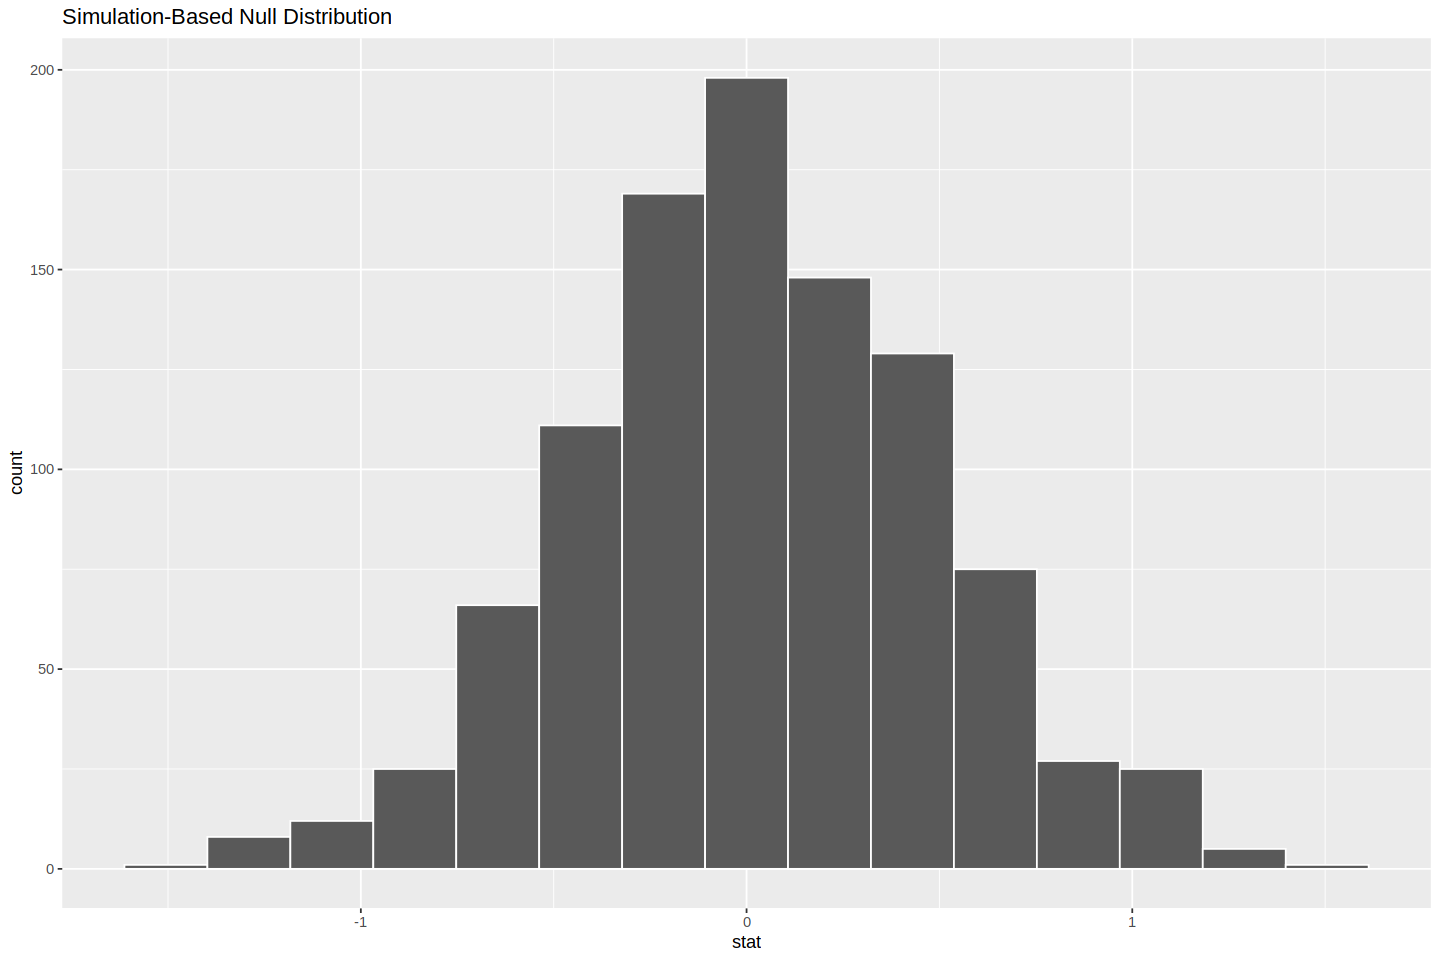

In [7]:
set.seed(39)
null_sim <- student_data_clean  %>%
  specify(G3 ~ high_alc) %>%
  hypothesize(null = "independence") %>%
  generate(reps = 1000, type = "permute") %>%
  calculate(
    stat = "diff in means",
    order = c("FALSE", "TRUE")
  )

null_sim %>% visualize()

Next, we will calculate the point statistic:

In [8]:
obs_diff <- student_data_clean %>%
  specify(G3 ~ high_alc) %>%
  calculate(
    stat = "diff in means",
    order = c(FALSE, TRUE)
  )
obs_diff

stat
<dbl>
0.2106918


Now we will shade where this statistic is found on our null distribution.

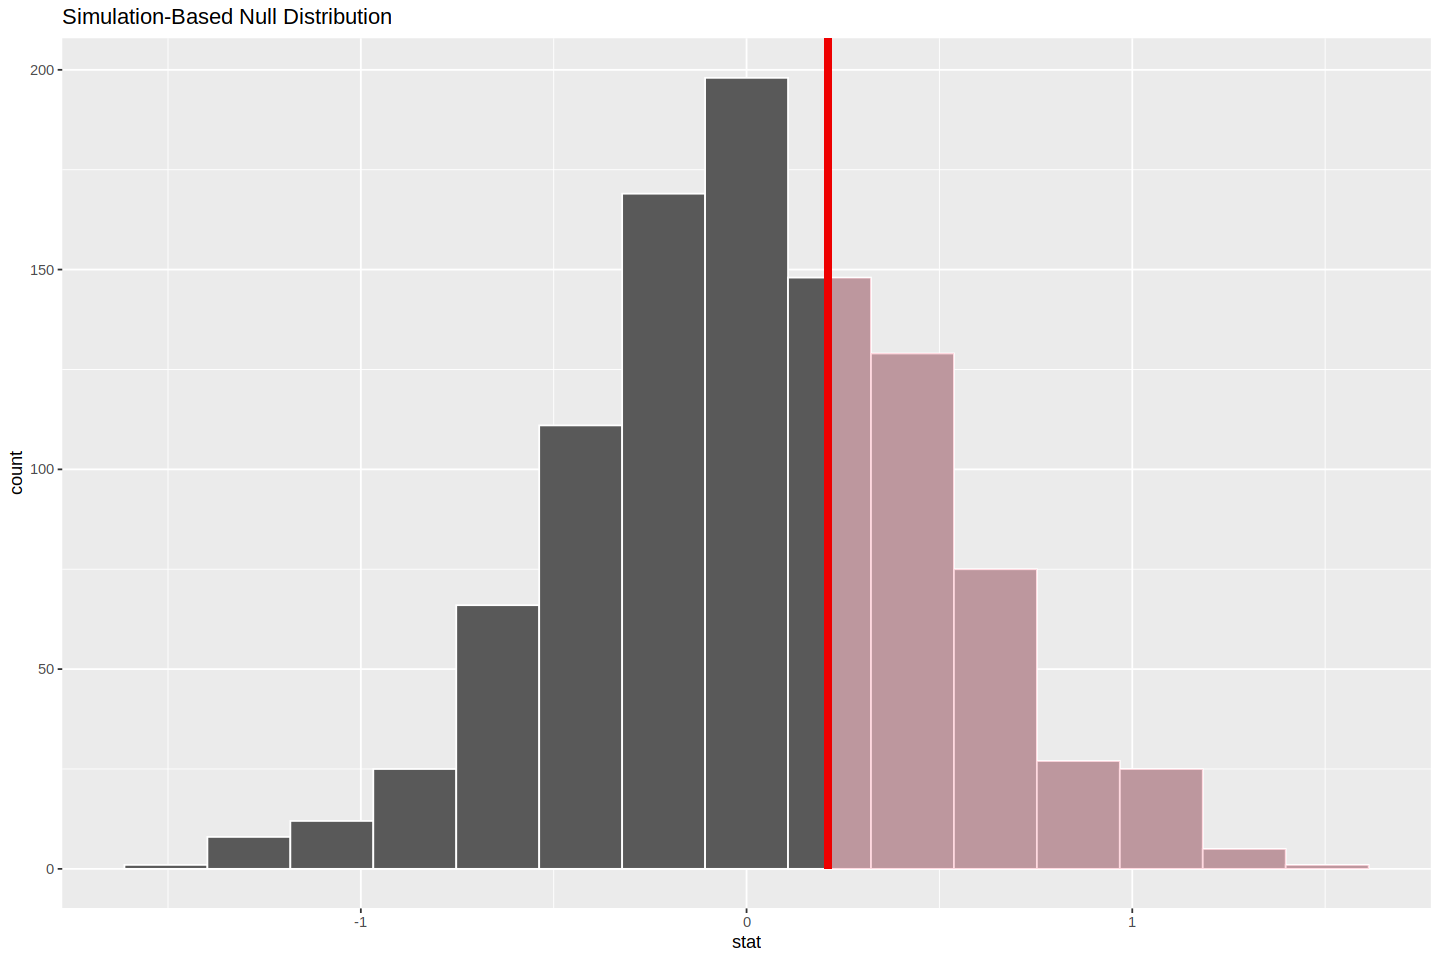

In [9]:
null_sim %>%
  visualize() +
  shade_p_value(obs_stat = obs_diff, direction = "greater")

Which leads us to the simulation-derived p-value of:

In [10]:
pvalue <- null_sim %>%
  get_pvalue(obs_stat = obs_diff, direction = "greater")
pvalue

p_value
<dbl>
0.329


Our simulation-based hypothesis test finds a p-value of $0.319$.

We can then find 95% confidence interval for the difference of means, again with the `infer` package.

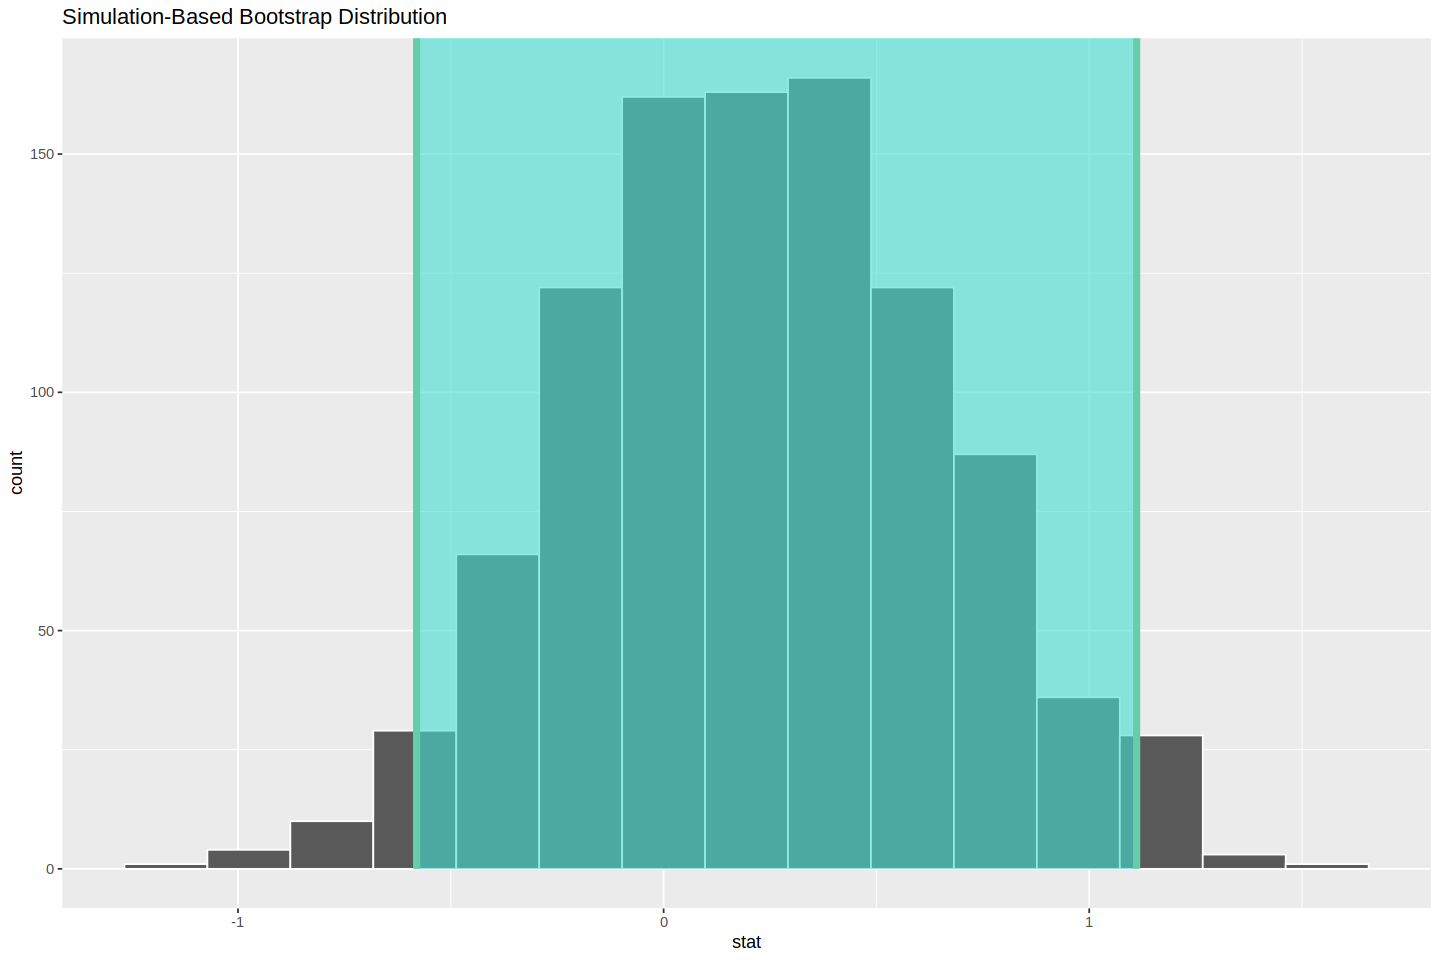

In [20]:
boot_ci <- student_data_clean %>%
  specify(G3 ~ high_alc) %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(
    stat = "diff in means",
    order = c(FALSE, TRUE)
)

conf_in <-   boot_ci %>%
    get_ci(level = 0.95)


boot_ci %>% visualize() +
    shade_ci(endpoints = conf_in)

Here, it is relevant to note that the value of zero (corresponding to the means being the same) is captured by the confidence interval.

#### Theory-Based Hypothesis Testing

After obtaining a value from our simulation-based hypothesis testing, we are interested in determining any potential differences between our simulation-based test and a theory-based test. From our preliminary analysis, our data does not fully follow a normal distribution. However, the sample size is large enough for the Central Limit Theorem to apply, and it is suitable to use traditional theoretical hypothesis testing methods on the data. In particular, the most suitable test is a t-test for a difference in means of two independent groups.

$$t =\frac{ (\bar{x}_1 - \bar{x}_2)}{ \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [11]:
student_summary

high_alc,count,mean_grade,sd_grade
<lgl>,<int>,<dbl>,<dbl>
FALSE,236,10.50000,5.067628
TRUE,159,10.28931,3.757433


Our preliminary summary information provides us with all the information we need to calculate the p-value using a t-distribution with 158 degrees of freedom.

In [12]:
high_alc_mean <- student_summary$mean_grade[[1]]
low_alc_mean <- student_summary$mean_grade[[2]]
high_alc_sd <- student_summary$sd_grade[[1]]
low_alc_sd <- student_summary$sd_grade[[2]]
high_alc_n <- student_summary$count[[1]]
low_alc_n <- student_summary$count[[2]]

test_statistic <- abs(high_alc_mean - low_alc_mean) / sqrt(high_alc_sd ** 2 / high_alc_n + low_alc_sd ** 2 / low_alc_n)
p_value <- pt(test_statistic, df = high_alc_n + low_alc_n - 2, lower.tail = FALSE)
p_value

[1] 0.3178959

Our theory-based hypothesis test finds a p-value of $0.318$.

We can then complete this analysis by providing a theory-based confidence interval for the difference in means.

In [25]:
upper_ci <- abs(high_alc_mean - low_alc_mean) + qt(0.95, df = high_alc_n + low_alc_n - 2) * sqrt(high_alc_sd ** 2 / high_alc_n + low_alc_sd ** 2 / low_alc_n)
lower_ci <- abs(high_alc_mean - low_alc_mean) - qt(0.95, df = high_alc_n + low_alc_n - 2) * sqrt(high_alc_sd ** 2 / high_alc_n + low_alc_sd ** 2 / low_alc_n)
upper_ci
lower_ci

[1] 0.9436148

[1] -0.5222312

We find a theory-based confidence interval spanning from $\approx -0.522$ to $\approx 0.944$. This is relatively consistent with our bootstrap distribution, and also includes zero among the values captured.

# Discussion

# References

(1). Michael J. Eckardt, Sandra E. File, et.Effects of Moderate Alcohol Consumption on the Central Nervous System. 30 May 2006. https://doi.org/10.1111/j.1530-0277.1998.tb03695.x

(2). Bushman, B. J., & Cooper, H. M. . Effects of alcohol on human aggression: An intergrative research review. Psychological Bulletin, 107(3), 341–354.(1990). https://doi.org/10.1037/0033-2909.107.3.341

(3). El Ansari W, Stock C, Mills C. Is alcohol consumption associated with poor academic achievement in university students? Int J Prev Med. Oct 2013;4(10):1175-88. PMID: 24319558; PMCID: PMC3843305. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3843305/
